In [1]:



import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch.optim as optim

transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15),  
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])



train_data = datasets.ImageFolder(r'C:\Users\ssaia\.keras\datasets\cats_and_dogs_filtered\train', transform=transform)
test_data = datasets.ImageFolder(r'C:\Users\ssaia\.keras\datasets\cats_and_dogs_filtered\validation', transform=transform)


num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)


In [2]:

results = {}



In [3]:

class CNNNet1(nn.Module):
    def __init__(self, num_classes):
        super(CNNNet1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "CNN_model1"
model = CNNNet1(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
results[model_name] = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': [], 'test_loss': None, 'cat_accuracy': None, 'dog_accuracy': None, 'overall_accuracy': None}

n_epochs = 10

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()
    
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    results[model_name]['train_loss'].append(train_loss)
    results[model_name]['valid_loss'].append(valid_loss)


Epoch: 1 	Training Loss: 0.754848 	Validation Loss: 0.693572
Epoch: 2 	Training Loss: 0.693837 	Validation Loss: 0.693050
Epoch: 3 	Training Loss: 0.694387 	Validation Loss: 0.693175
Epoch: 4 	Training Loss: 0.693758 	Validation Loss: 0.693036
Epoch: 5 	Training Loss: 0.693922 	Validation Loss: 0.693270
Epoch: 6 	Training Loss: 0.693445 	Validation Loss: 0.693202
Epoch: 7 	Training Loss: 0.693237 	Validation Loss: 0.693128
Epoch: 8 	Training Loss: 0.693734 	Validation Loss: 0.692770
Epoch: 9 	Training Loss: 0.693281 	Validation Loss: 0.693067
Epoch: 10 	Training Loss: 0.693705 	Validation Loss: 0.693229


In [5]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(data.size(0)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss /= len(test_loader.dataset)
cat_accuracy = 100 * class_correct[0] / class_total[0]
dog_accuracy = 100 * class_correct[1] / class_total[1]
overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)

results[model_name].update({'test_loss': test_loss, 'cat_accuracy': cat_accuracy, 'dog_accuracy': dog_accuracy, 'overall_accuracy': overall_accuracy})





print(f"Results for ",model_name)
print(f"Cat Accuracy: {cat_accuracy:.2f}%")
print(f"Dog Accuracy: {dog_accuracy:.2f}%")
print(f"Overall Test Accuracy: {overall_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.6f}")


Results for  CNN_model1
Cat Accuracy: 0.00%
Dog Accuracy: 100.00%
Overall Test Accuracy: 50.00%
Test Loss: 0.693169


In [6]:
print(results)

{'CNN_model1': {'train_loss': [0.7548475050926209, 0.6938373208045959, 0.6943873906135559, 0.6937582445144653, 0.6939224505424499, 0.6934454917907715, 0.6932367086410522, 0.6937339377403259, 0.6932809948921204, 0.6937051963806152], 'valid_loss': [0.693571788924081, 0.6930498225348336, 0.693175060408456, 0.6930363178253174, 0.6932700276374817, 0.6932019761630467, 0.6931281770978656, 0.6927702171461922, 0.6930669460977826, 0.6932290281568255], 'train_accuracy': [], 'valid_accuracy': [], 'test_loss': 0.6931693606376648, 'cat_accuracy': 0.0, 'dog_accuracy': 100.0, 'overall_accuracy': 50.0}}


In [7]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "AlexNet"
model = AlexNet(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
results[model_name] = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': [], 'test_loss': None, 'cat_accuracy': None, 'dog_accuracy': None, 'overall_accuracy': None}

n_epochs = 10

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()
    

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    results[model_name]['train_loss'].append(train_loss)
    results[model_name]['valid_loss'].append(valid_loss)


Epoch: 1 	Training Loss: 3229.046465 	Validation Loss: 0.696714
Epoch: 2 	Training Loss: 0.716915 	Validation Loss: 0.712782
Epoch: 3 	Training Loss: 1.518986 	Validation Loss: 0.695684
Epoch: 4 	Training Loss: 0.698375 	Validation Loss: 0.699776
Epoch: 5 	Training Loss: 1.000081 	Validation Loss: 0.702460
Epoch: 6 	Training Loss: 0.704483 	Validation Loss: 0.693644
Epoch: 7 	Training Loss: 0.694404 	Validation Loss: 0.693782
Epoch: 8 	Training Loss: 0.696105 	Validation Loss: 0.693627
Epoch: 9 	Training Loss: 0.695702 	Validation Loss: 0.693666
Epoch: 10 	Training Loss: 0.697660 	Validation Loss: 0.693833


In [9]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(data.size(0)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss /= len(test_loader.dataset)
cat_accuracy = 100 * class_correct[0] / class_total[0]
dog_accuracy = 100 * class_correct[1] / class_total[1]
overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)

results[model_name].update({'test_loss': test_loss, 'cat_accuracy': cat_accuracy, 'dog_accuracy': dog_accuracy, 'overall_accuracy': overall_accuracy})


In [10]:


print(f"Results for ",model_name)
print(f"Cat Accuracy: {cat_accuracy:.2f}%")
print(f"Dog Accuracy: {dog_accuracy:.2f}%")
print(f"Overall Test Accuracy: {overall_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.6f}")

Results for  AlexNet
Cat Accuracy: 100.00%
Dog Accuracy: 0.00%
Overall Test Accuracy: 50.00%
Test Loss: 0.693236


In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.input_fc = nn.Linear(input_dim, 512) 
        self.hidden_fc = nn.Linear(512, 256) 
        self.output_fc = nn.Linear(256, output_dim) 

    def forward(self, x):
        x = x.view(x.shape[0], -1) 
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "MLP"
model = MLP(input_dim=3072, output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
results[model_name] = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': [], 'test_loss': None, 'cat_accuracy': None, 'dog_accuracy': None, 'overall_accuracy': None}


In [13]:
n_epochs = 10

for epoch in range(1, n_epochs + 1):
    train_loss, valid_loss = 0.0, 0.0

    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()
    

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    results[model_name]['train_loss'].append(train_loss)
    results[model_name]['valid_loss'].append(valid_loss)


Epoch: 1 	Training Loss: 0.708043 	Validation Loss: 0.699535
Epoch: 2 	Training Loss: 0.684784 	Validation Loss: 0.677684
Epoch: 3 	Training Loss: 0.668122 	Validation Loss: 0.678572
Epoch: 4 	Training Loss: 0.664993 	Validation Loss: 0.662945
Epoch: 5 	Training Loss: 0.662839 	Validation Loss: 0.667972
Epoch: 6 	Training Loss: 0.656012 	Validation Loss: 0.680634
Epoch: 7 	Training Loss: 0.641816 	Validation Loss: 0.684512
Epoch: 8 	Training Loss: 0.639120 	Validation Loss: 0.665901
Epoch: 9 	Training Loss: 0.643912 	Validation Loss: 0.675280
Epoch: 10 	Training Loss: 0.632569 	Validation Loss: 0.668888


In [14]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(data.size(0)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss /= len(test_loader.dataset)
cat_accuracy = 100 * class_correct[0] / class_total[0]
dog_accuracy = 100 * class_correct[1] / class_total[1]
overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)

results[model_name].update({'test_loss': test_loss, 'cat_accuracy': cat_accuracy, 'dog_accuracy': dog_accuracy, 'overall_accuracy': overall_accuracy})


In [15]:


print(f"Results for ",model_name)
print(f"Cat Accuracy: {cat_accuracy:.2f}%")
print(f"Dog Accuracy: {dog_accuracy:.2f}%")
print(f"Overall Test Accuracy: {overall_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.6f}")

Results for  MLP
Cat Accuracy: 73.20%
Dog Accuracy: 39.00%
Overall Test Accuracy: 56.10%
Test Loss: 0.703043


In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_data = datasets.ImageFolder(r'C:\Users\ssaia\.keras\datasets\cats_and_dogs_filtered\train', transform=transform)
test_data = datasets.ImageFolder(r'C:\Users\ssaia\.keras\datasets\cats_and_dogs_filtered\validation', transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)


In [17]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

Using cache found in C:\Users\ssaia/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\ssaia/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\ssaia/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomEfficientNet(nn.Module):
    def __init__(self, original_model):
        super(CustomEfficientNet, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        

        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(1280 * 7 * 7, 512)
        
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):

        x = self.features(x)
        

        x = torch.flatten(x, 1)
        

        x = self.dropout(x)
        

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [19]:
import torch
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomEfficientNet(efficientnet).to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
n_epochs = 10
model_name = "EfficientNet"
results[model_name] = {'train_loss': [], 'valid_loss': [], 'train_accuracy': [], 'valid_accuracy': [], 'test_loss': None, 'cat_accuracy': None, 'dog_accuracy': None, 'overall_accuracy': None}
for epoch in range(n_epochs):
    model.train()  
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    

    valid_loss = 0.0
    model.eval()  
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    results[model_name]['train_loss'].append(train_loss)
    results[model_name]['valid_loss'].append(valid_loss)



Epoch: 0 	Training Loss: 0.415435 	Validation Loss: 3.868625
Epoch: 1 	Training Loss: 0.048100 	Validation Loss: 0.279112
Epoch: 2 	Training Loss: 0.030139 	Validation Loss: 0.125464
Epoch: 3 	Training Loss: 0.009319 	Validation Loss: 0.118074
Epoch: 4 	Training Loss: 0.002548 	Validation Loss: 0.191217
Epoch: 5 	Training Loss: 0.002784 	Validation Loss: 0.169752
Epoch: 6 	Training Loss: 0.000611 	Validation Loss: 0.170055
Epoch: 7 	Training Loss: 0.018296 	Validation Loss: 0.337161
Epoch: 8 	Training Loss: 0.034884 	Validation Loss: 0.621753
Epoch: 9 	Training Loss: 0.076294 	Validation Loss: 0.200578


In [21]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(data.size(0)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss /= len(test_loader.dataset)
cat_accuracy = 100 * class_correct[0] / class_total[0]
dog_accuracy = 100 * class_correct[1] / class_total[1]
overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)

results[model_name].update({'test_loss': test_loss, 'cat_accuracy': cat_accuracy, 'dog_accuracy': dog_accuracy, 'overall_accuracy': overall_accuracy})





print(f"Results for ",model_name)
print(f"Cat Accuracy: {cat_accuracy:.2f}%")
print(f"Dog Accuracy: {dog_accuracy:.2f}%")
print(f"Overall Test Accuracy: {overall_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.6f}")


Results for  EfficientNet
Cat Accuracy: 96.20%
Dog Accuracy: 94.80%
Overall Test Accuracy: 95.50%
Test Loss: 0.114424


In [22]:
results

{'CNN_model1': {'train_loss': [0.7548475050926209,
   0.6938373208045959,
   0.6943873906135559,
   0.6937582445144653,
   0.6939224505424499,
   0.6934454917907715,
   0.6932367086410522,
   0.6937339377403259,
   0.6932809948921204,
   0.6937051963806152],
  'valid_loss': [0.693571788924081,
   0.6930498225348336,
   0.693175060408456,
   0.6930363178253174,
   0.6932700276374817,
   0.6932019761630467,
   0.6931281770978656,
   0.6927702171461922,
   0.6930669460977826,
   0.6932290281568255],
  'train_accuracy': [],
  'valid_accuracy': [],
  'test_loss': 0.6931693606376648,
  'cat_accuracy': 0.0,
  'dog_accuracy': 100.0,
  'overall_accuracy': 50.0},
 'AlexNet': {'train_loss': [3229.0464646959304,
   0.7169153332710266,
   1.518986132144928,
   0.698375494480133,
   1.0000814533233642,
   0.7044834995269775,
   0.6944037985801697,
   0.696105465888977,
   0.6957019424438476,
   0.6976603937149047],
  'valid_loss': [0.6967136859893799,
   0.7127823403903416,
   0.69568418604987,
   0

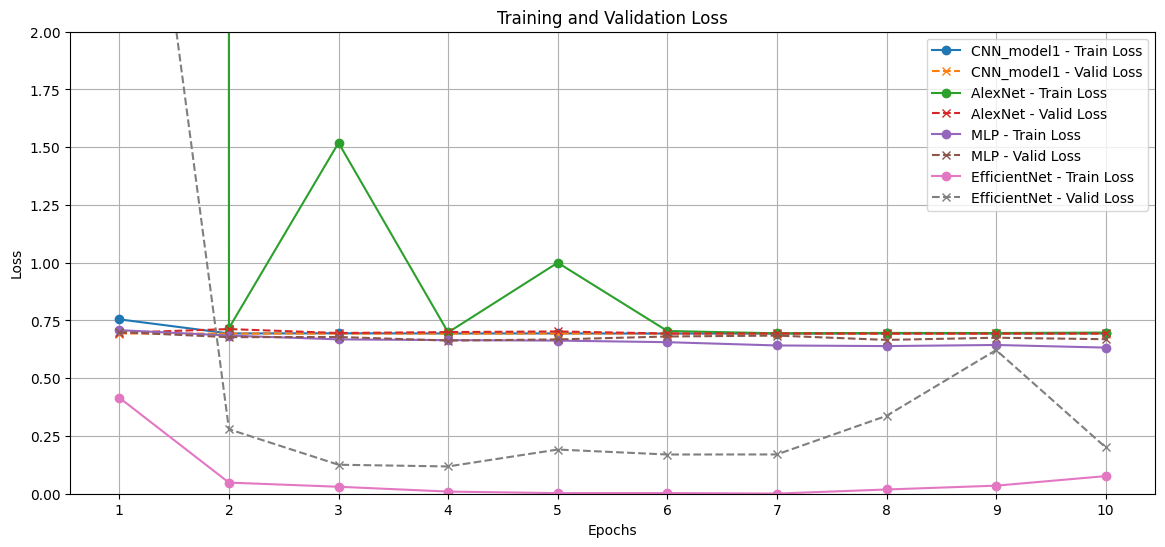

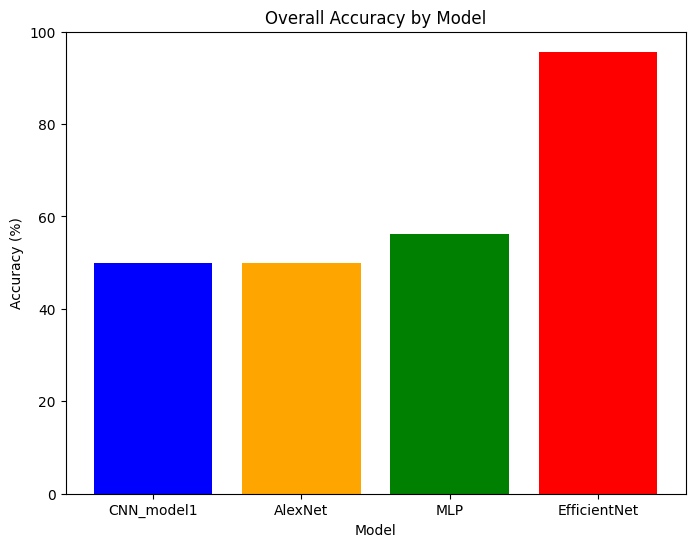

In [28]:

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
epochs = list(range(1, 11))
for model_name, metrics in results.items():
    plt.plot(epochs, metrics['train_loss'], label=f"{model_name} - Train Loss", linestyle='-', marker='o')
    plt.plot(epochs, metrics['valid_loss'], label=f"{model_name} - Valid Loss", linestyle='--', marker='x')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)  
plt.ylim(0, 2)  
plt.show()


plt.figure(figsize=(8, 6))

plt.bar(names, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title('Overall Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()

